<a href="https://colab.research.google.com/github/Maziger/Laksegate-master-thesis/blob/main/POC/experiment_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with lstm

Predcition on German day-ahead prices. Data: https://github.com/jeslago/epftoolbox.

In [ ]:
import os
from google.colab import userdata

user = "Maziger"
repo = "Laksegate-master-thesis"

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git
%cd Laksegate-master-thesis/

Cloning into 'Laksegate-master-thesis'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 1.09 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/Laksegate-master-thesis


In [ ]:
import pandas as pd
path = "POC/Forecasts_DE_DNN_LEAR_ensembles.csv"
data = pd.read_csv(path)
data = data[['Unnamed: 0', 'Real price']]
train = data[:14000]
test = data[14000:]

# Task
Build and evaluate an LSTM model for electricity price forecasting using the "POC/Forecasts_DE_DNN_LEAR_ensembles.csv" file, including data preprocessing, model training, prediction, evaluation, and visualization of results.

## Preprocess Data for LSTM

### Subtask:
Convert the 'Unnamed: 0' column to datetime objects, set it as the index, normalize the 'Real price' column using a MinMaxScaler, and create time-series sequences suitable for LSTM input from both the training and testing datasets.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train['Unnamed: 0'] = pd.to_datetime(train['Unnamed: 0'])
train = train.set_index('Unnamed: 0')
train.index.name = 'Date'

test['Unnamed: 0'] = pd.to_datetime(test['Unnamed: 0'])
test = test.set_index('Unnamed: 0')
test.index.name = 'Date'

# Instantiate a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0,1))

# Reshape and fit scaler on train data, then transform both train and test
# Store scaled data in new columns
train_scaled = scaler.fit_transform(train['Real price'].values.reshape(-1,1))
test_scaled = scaler.transform(test['Real price'].values.reshape(-1,1))

# Define a function to create sequences for LSTM
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Apply the sequence creation function
time_step = 100
X_train, y_train = create_sequences(train_scaled, time_step)
X_test, y_test = create_sequences(test_scaled, time_step)

# Reshape X_train and X_test for LSTM input [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (13900, 100, 1)
Shape of y_train: (13900,)
Shape of X_test: (3372, 100, 1)
Shape of y_test: (3372,)


/tmp/ipython-input-3249714847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Unnamed: 0'] = pd.to_datetime(train['Unnamed: 0'])
/tmp/ipython-input-3249714847.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Unnamed: 0'] = pd.to_datetime(test['Unnamed: 0'])


## Build and Compile LSTM Model

### Subtask:
Define the architecture of a simple LSTM model using Keras/TensorFlow, specifying appropriate input shape, LSTM layers, and dense output layers. Compile the model with an optimizer (e.g., Adam) and a loss function suitable for regression (e.g., Mean Squared Error).


**Reasoning**:
To define the LSTM model architecture, I need to import the necessary modules from Keras, then create a Sequential model, add LSTM layers, Dropout layers, and a Dense output layer with the specified parameters, and finally compile the model.



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# 1. Initialize a Sequential model
model = Sequential()

# Add an Input layer explicitly as the first layer
model.add(Input(shape=(time_step, 1)))

# 2. Add the first LSTM layer with 50 units and return_sequences=True
model.add(LSTM(units=50, return_sequences=True))

# 3. Add a Dropout layer with a dropout rate of 0.2
model.add(Dropout(0.2))

# 4. Add a second LSTM layer with 50 units and return_sequences=False
model.add(LSTM(units=50, return_sequences=False))

# 5. Add another Dropout layer with a dropout rate of 0.2
model.add(Dropout(0.2))

# 6. Add a Dense output layer with 1 unit
model.add(Dense(units=1))

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Train LSTM Model

### Subtask:
Train the compiled LSTM model using the preprocessed training data (input sequences and corresponding target values). Monitor the training process, potentially using a validation split.


**Reasoning**:
To train the compiled LSTM model, I will use the `model.fit()` method, providing the training and validation data, along with the specified epochs and batch size. The training history will be stored for subsequent analysis.



In [ ]:
epochs = 50
batch_size = 64

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Model training complete.")

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0310 - val_loss: 0.0022
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 12/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 

## Make Predictions and Evaluate Model

### Subtask:
Generate predictions using the trained LSTM model on the test dataset, inverse transform the predictions and actual values to their original scale, and evaluate the model's performance using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

**Reasoning**:
First, I will use the trained `model` to generate predictions on the `X_test` dataset. Then, since the data was scaled, I need to inverse transform both the `y_test` (actual values) and the `test_predict` (predicted values) back to their original scale using the `scaler` object. Finally, I will calculate the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) to assess the model's accuracy.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions
test_predict = model.predict(X_test)

# Inverse transform predictions and y_test to original scale
test_predict_original = scaler.inverse_transform(test_predict)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, test_predict_original))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Calculate MAE
mae = mean_absolute_error(y_test_original, test_predict_original)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Root Mean Squared Error (RMSE): 5.8598
Mean Absolute Error (MAE): 3.9263


## Visualize Predictions

### Subtask:
Visualize the actual electricity prices against the LSTM model's predictions on the test dataset to qualitatively assess model performance.

**Reasoning**:
To visualize the model's performance, I will plot the actual `Real price` from the `test` dataset alongside the inverse-transformed `test_predict_original` values. This will allow for a direct comparison of the predicted and actual electricity prices over time.

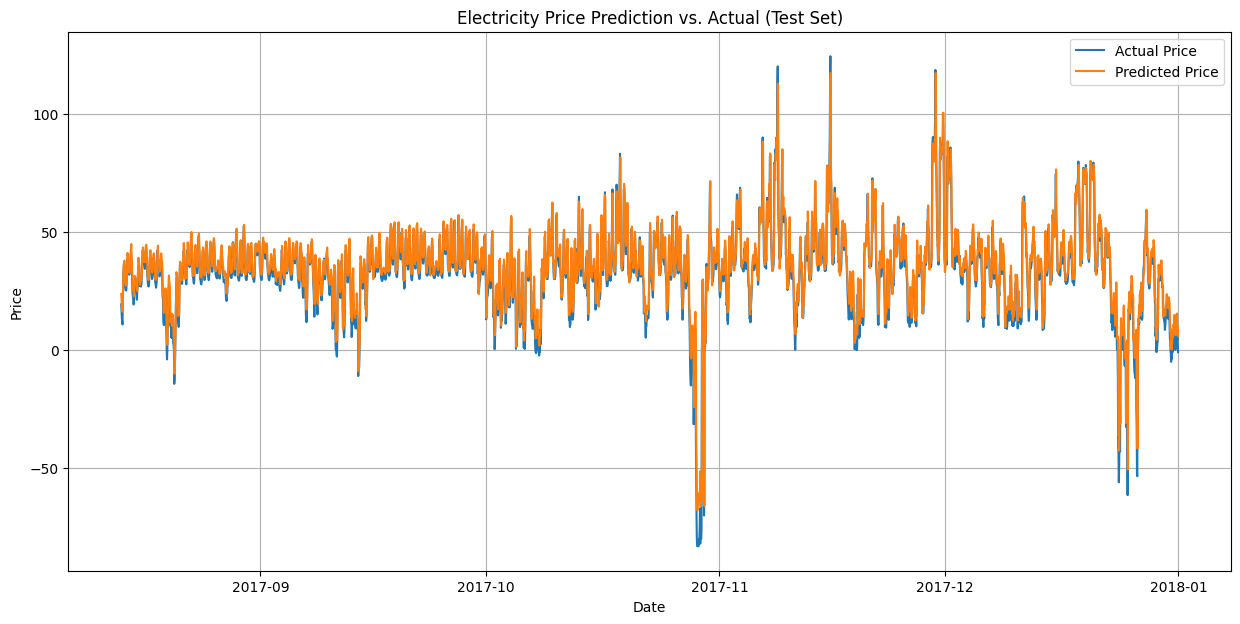

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for plotting
plot_df = test[time_step:].copy() # Align with y_test
plot_df['Actual Price'] = y_test_original
plot_df['Predicted Price'] = test_predict_original

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(plot_df.index, plot_df['Actual Price'], label='Actual Price')
plt.plot(plot_df.index, plot_df['Predicted Price'], label='Predicted Price')
plt.title('Electricity Price Prediction vs. Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Predict Next 24 Hours

**Reasoning**:
To predict the next 24 hours, I will combine the `train_scaled` and `test_scaled` data to get the complete sequence. I'll then extract the last `time_step` values to use as the initial input for the model. I will iteratively predict 24 future values, feeding each prediction back into the input sequence, and finally inverse transform these predictions to display them in their original scale.

In [ ]:
import numpy as np
import pandas as pd

# Combine train and test scaled data to get the full sequence for prediction
full_scaled_data = np.concatenate((train_scaled, test_scaled), axis=0)

# Get the last 'time_step' data points from the full scaled dataset for initial prediction input
x_input = full_scaled_data[len(full_scaled_data) - time_step:].reshape(1, -1, 1)

future_predictions = []
num_future_steps = 72  # Predict next 72 hours

for _ in range(num_future_steps):
    # Predict the next value
    next_prediction = model.predict(x_input, verbose=0)[0]
    future_predictions.append(next_prediction[0])

    # Update x_input: remove the first element and add the new prediction
    x_input = np.append(x_input[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions to the original scale
future_predictions_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Get the last timestamp from the test set
last_test_date = test.index[-1]

# Create a date range for the next 72 hours
future_dates = pd.date_range(start=last_test_date + pd.Timedelta(hours=1), periods=num_future_steps, freq='H')

# Display the future predictions
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions_original.flatten()})
future_predictions_df.set_index('Date', inplace=True)
print("Next 72-hour predictions:")
print(future_predictions_df)

Next 72-hour predictions:
                     Predicted Price
Date                                
2018-01-01 00:00:00         2.990620
2018-01-01 01:00:00         8.027471
2018-01-01 02:00:00        13.499473
2018-01-01 03:00:00        18.339556
2018-01-01 04:00:00        22.688313
...                              ...
2018-01-03 19:00:00        56.376324
2018-01-03 20:00:00        55.968071
2018-01-03 21:00:00        55.447781
2018-01-03 22:00:00        54.928417
2018-01-03 23:00:00        54.531105

[72 rows x 1 columns]


/tmp/ipython-input-773459819.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_test_date + pd.Timedelta(hours=1), periods=num_future_steps, freq='H')


## Visualize Future Predictions

**Reasoning**:
To provide a comprehensive visualization, I will extend the previous plot to include the newly generated 24-hour future predictions. This will allow for a clear comparison of actual prices, past predictions, and the forecasted future prices on a single graph.

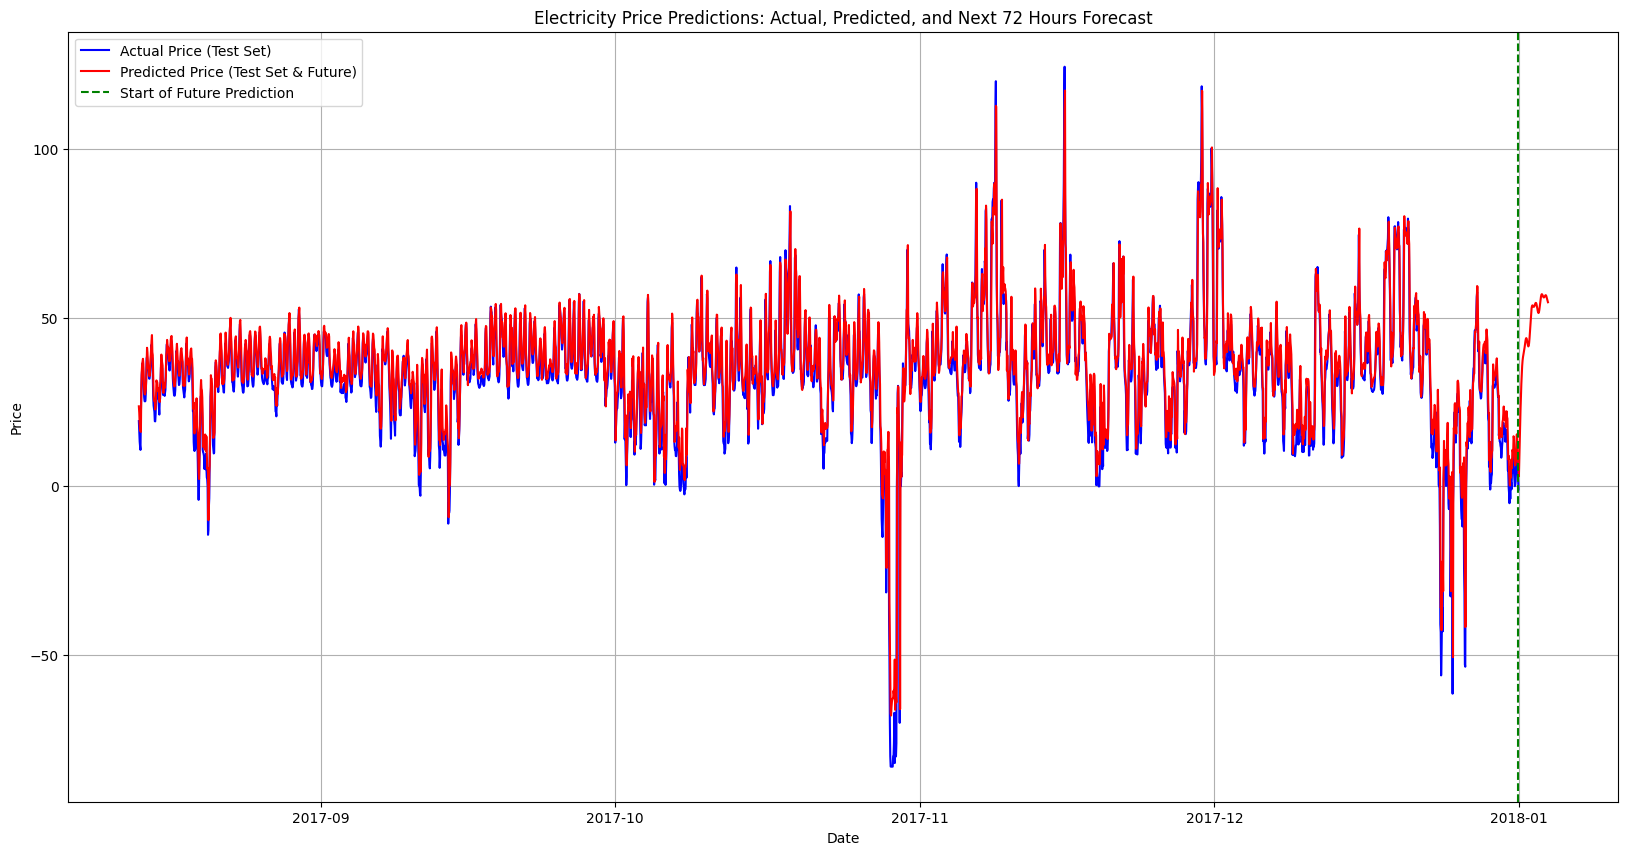

In [ ]:
import matplotlib.pyplot as plt

# Create a combined DataFrame for plotting, including past and future predictions

# Ensure plot_df from previous step is available or recreate it
# If it's not available due to a new session, uncomment and run:
# plot_df = test[time_step:].copy()
# plot_df['Actual Price'] = y_test_original
# plot_df['Predicted Price'] = test_predict_original

# Add future predictions to the plot_df for visualization
# Create a temporary DataFrame for future predictions with matching columns
future_plot_df = pd.DataFrame({
    'Actual Price': np.nan, # No actual prices for future predictions
    'Predicted Price': future_predictions_original.flatten()
}, index=future_dates)

# Concatenate the test set visualization data with future predictions
combined_plot_df = pd.concat([plot_df, future_plot_df])

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(combined_plot_df.index, combined_plot_df['Actual Price'], label='Actual Price (Test Set)', color='blue')
plt.plot(combined_plot_df.index, combined_plot_df['Predicted Price'], label='Predicted Price (Test Set & Future)', color='red')

# Highlight the future prediction region
plt.axvline(x=last_test_date, color='green', linestyle='--', label='Start of Future Prediction')

plt.title('Electricity Price Predictions: Actual, Predicted, and Next 72 Hours Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()